In [1]:
from TSInterpret.data import load_data
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import os 

# Parameters

In [2]:
dataset='ElectricDevices'

# Load Data

In [3]:
#TODO include OneHot Encoding Options
train_x,test_x, train_y, test_y = load_data.load_basic_dataset(dataset,scaling=None,mode='feat',cwd='/media/jacqueline/Data/UCRArchive_2018/')

In [4]:
print(test_y.shape)

(7711,)


In [5]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

# Model Training

In [6]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
fit(model,train_loader,test_loader)
if dataset in os.listdir('../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'../ClassificationModels/models/{dataset}/ResNet')

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)

sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'../ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'../ClassificationModels/models/{dataset}/classification_report.csv', index = False)

Epoch: 1, Train loss: 0.845, Val loss: 1.32
Epoch: 2, Train loss: 0.734, Val loss: 1.827
Epoch: 3, Train loss: 0.523, Val loss: 1.774
Epoch: 4, Train loss: 0.48, Val loss: 1.39
Epoch: 5, Train loss: 0.433, Val loss: 1.844
Epoch: 6, Train loss: 0.408, Val loss: 1.522
Epoch: 7, Train loss: 0.393, Val loss: 2.067
Epoch: 8, Train loss: 0.371, Val loss: 1.413
Epoch: 9, Train loss: 0.353, Val loss: 1.489
Epoch: 10, Train loss: 0.335, Val loss: 1.536
Epoch: 11, Train loss: 0.331, Val loss: 1.942
Epoch: 12, Train loss: 0.32, Val loss: 1.465
Epoch: 13, Train loss: 0.3, Val loss: 2.973
Epoch: 14, Train loss: 0.298, Val loss: 1.952
Epoch: 15, Train loss: 0.271, Val loss: 1.506
Epoch: 16, Train loss: 0.267, Val loss: 2.243
Epoch: 17, Train loss: 0.255, Val loss: 1.669
Epoch: 18, Train loss: 0.254, Val loss: 2.141
Epoch: 19, Train loss: 0.24, Val loss: 2.11
Epoch: 20, Train loss: 0.226, Val loss: 2.127
Epoch: 21, Train loss: 0.219, Val loss: 2.357
Epoch: 22, Train loss: 0.219, Val loss: 1.963
Epoch

# Explanation Algo

In [7]:
item=test_x[10].reshape(1,1,-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
#y_target= model(_item).detach().numpy()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [8]:
print(y_target)

[[4.5297136e-16 2.5197947e-20 1.4002514e-30 8.4086096e-06 6.9493616e-10
  9.9992847e-01 6.3029998e-05]]


In [9]:
from TSInterpret.InterpretabilityModels.counterfactual.NativeGuideCF import NativeGuideCF
exp_model=NativeGuideCF(model,shape,(train_x,train_y), backend='PYT', mode='feat')

In [10]:
exp,label=exp_model.explain(item, np.argmax(y_target,axis=1),method='native_guide')

[5]
Native Guide [[2.2530171e-01 6.0941478e-05 1.8320753e-01 5.2965921e-01 3.7634991e-02
  3.5855315e-05 2.4099732e-02]]
Starting Points 8
Subarray Length 1
Prob_target [0.9999281]
starting 7
2
False
Prob_target [0.9992518]
starting 92
3
False
Prob_target [0.9997954]
starting 91
4
False
Prob_target [0.99974626]
starting 91
5
False
Prob_target [0.9992157]
starting 90
6
False
Prob_target [0.99834335]
starting 35
7
False
Prob_target [0.99481565]
starting 35
8
False
Prob_target [0.99700886]
starting 0
9
False
Prob_target [0.99996805]
starting 0
10
False
Prob_target [0.9999702]
starting 0
11
False
Prob_target [0.99999225]
starting 0
12
False
Prob_target [0.78493685]
starting 0
13
False
Prob_target [0.99991655]
starting 0
14
False
Prob_target [0.9999728]
starting 0
15
False
Prob_target [0.9996989]
starting 0
16
False
Prob_target [0.99988663]
starting 0
17
False
Prob_target [0.99999523]
starting 0
18
False
Prob_target [0.99999714]
starting 0
19
False
Prob_target [0.99999845]
starting 0
20
Fal

In [11]:
label=0

In [12]:
print(exp)

[[-0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752
  -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752
  -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752
  -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752
  -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752
  -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752
  -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752
  -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752 -0.13949752
  -0.13949752 -0.13949752 -0.13949752 -0.13949752  8.45354939  4.65921688
  -0.13949752 -0.13949752  0.23510956 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841 -0.24948841
  -0.24948841 -0.24948841 -0.24948841 

In [13]:
print(exp.shape)

(1, 96)


# Plot Item 

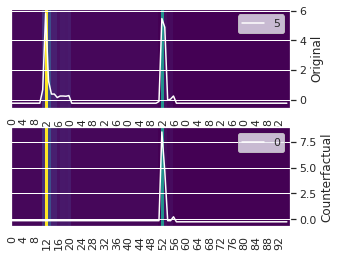

In [14]:

exp_model.plot(item,np.argmax(y_target,axis=1)[0],exp,label)

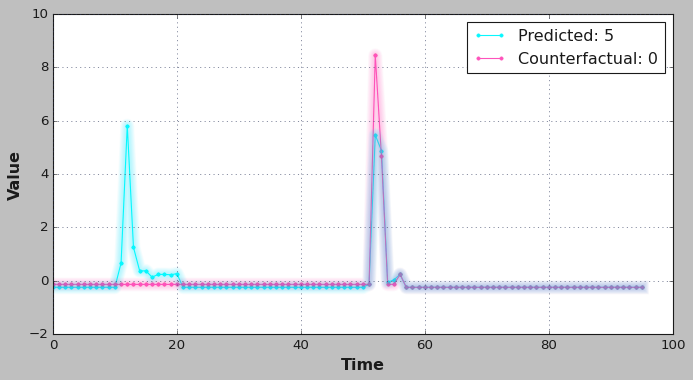

In [15]:
exp_model.plot_in_one(item,np.argmax(y_target,axis=1)[0],exp,label)